In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from glob import glob

In [2]:
# path to detectin results
detect_res_path = "exp/"
detect_labels_res_path = os.path.join(detect_res_path, "labels")

# path to true labels
true_labeled_imgs_path = "../create_train_set/data/rgb_images_spag_&_bckg"
true_labels_path = "yolo-labels/"

In [3]:
detect_res_img_paths = glob(os.path.join(detect_res_path, "*"))
detect_txt_res_paths = glob(os.path.join(detect_labels_res_path, "*"))

true_labeled_img_paths = glob(os.path.join(true_labeled_imgs_path, "*"))
true_labels_paths = glob(os.path.join(true_labels_path, "*"))

In [4]:
def get_basename_no_ext(inp):
    return os.path.splitext(os.path.basename(inp[0]))[0]

def get_basenames_no_ext_arr(arr):
    arr_base = np.array(arr).reshape(-1,1)
    arr_base = np.apply_along_axis(get_basename_no_ext, 1, arr_base)
    return arr_base

def read_conf(img_name, detect_txt_res_paths):
    detect_txt_res_paths_base = get_basenames_no_ext_arr(detect_txt_res_paths)
    img_name_no_ext = os.path.splitext(os.path.basename(img_name))[0]
    
    if img_name_no_ext not in detect_txt_res_paths_base:
        return None
    txt_path = f"{os.path.dirname(detect_txt_res_paths[0])}/{img_name_no_ext}.txt"
    conf = []
    with open(txt_path) as fp:
        for line in fp:
            line = line.split(" ")
            if len(line) == 5:
                # print("ERROR: no conf saved")
                continue
            conf.append(float(line[5].strip()))
    return conf

def check_existance(img_name, true_labels_paths):
    true_labels_paths_base = get_basenames_no_ext_arr(true_labels_paths)
    img_name_no_ext = os.path.splitext(os.path.basename(img_name))[0]
    
    if img_name_no_ext in true_labels_paths_base:
        return True
    else:
        return False

def get_rows(detect_res_img_paths, detect_txt_res_paths, true_labeled_img_paths, true_labels_paths):
    rows = []
    for img_name in detect_res_img_paths:
        conf = read_conf(img_name, detect_txt_res_paths)
        
        true_result = check_existance(img_name, true_labels_paths)
        is_valid = check_existance(img_name, true_labeled_img_paths)
        
        im_name_base = os.path.basename(img_name)
        if conf is not None:
            for box_conf in conf:
                rows.append([im_name_base, box_conf, true_result, is_valid])
        else:
            rows.append([im_name_base, 0.0, true_result, is_valid])
    return rows

In [5]:
rows = get_rows(detect_res_img_paths, detect_txt_res_paths, true_labeled_img_paths, true_labels_paths)
rows_df = pd.DataFrame(rows, columns=['img_name', 'conf', 'true_res', 'is_valid'])

In [6]:
rows_df_grouped = rows_df.groupby(['img_name'])
imgs = rows_df.img_name.unique()
false_positives = pd.DataFrame()
for img in imgs:
    img_group = rows_df_grouped.get_group(img)
    
    # in event of false positive
    for bbox in range(len(img_group)):
        row = img_group.iloc[bbox]
        if (row.true_res == False) and (row.conf != 0.0):
            false_positives = false_positives.append(row)
    # break


In [7]:
rows_df_grouped = rows_df.groupby(['img_name'])
imgs = rows_df.img_name.unique()
true_positives = pd.DataFrame()
for img in imgs:
    img_group = rows_df_grouped.get_group(img)
    img_group = img_group.sort_values(by=['conf'], ascending='False')
    print(img_group)
    # in event of true positive
#     for bbox in range(len(img_group)):
    row = img_group.iloc[-1]
    if (row.true_res == True) and (row.conf != 0.0):
        true_positives = true_positives.append(row)
        print(row)
    # break

               img_name  conf  true_res  is_valid
0  72.afc88fb7f50ec.jpg   0.0     False      True
          img_name      conf  true_res  is_valid
1  13.problems.jpg  0.114597      True      True
img_name    13.problems.jpg
conf               0.114597
true_res               True
is_valid               True
Name: 1, dtype: object
                                            img_name  conf  true_res  is_valid
2  261.3d-printing-from-mass-production-to-custom...   0.0     False     False
                                            img_name  conf  true_res  is_valid
3  44.yolo-spaghetti-detection-certainty-values.-...   0.0     False     False
    img_name      conf  true_res  is_valid
4  105.4.png  0.058283      True      True
5  105.4.png  0.732112      True      True
img_name    105.4.png
conf         0.732112
true_res         True
is_valid         True
Name: 5, dtype: object
                                            img_name      conf  true_res  \
6   32.most-common-3d-printer-error

Name: 233, dtype: object
                img_name      conf  true_res  is_valid
234  54.vzzh4e8q0l8y.jpg  0.080506      True      True
235  54.vzzh4e8q0l8y.jpg  0.095352      True      True
236  54.vzzh4e8q0l8y.jpg  0.101517      True      True
237  54.vzzh4e8q0l8y.jpg  0.163652      True      True
img_name    54.vzzh4e8q0l8y.jpg
conf                   0.163652
true_res                   True
is_valid                   True
Name: 237, dtype: object
                                  img_name  conf  true_res  is_valid
238  370.htb10jlwmkombknjszfqq6xtqvxae.jpg   0.0     False     False
                             img_name      conf  true_res  is_valid
239  28.dafpczrw0aadlre.jpglarge.jpeg  0.698502      True     False
img_name    28.dafpczrw0aadlre.jpglarge.jpeg
conf                                0.698502
true_res                                True
is_valid                               False
Name: 239, dtype: object
                                            img_name     conf  true_

In [8]:
number_bck_images = len(rows_df[rows_df.true_res == False].img_name.unique())
number_bck_images

70

In [9]:
number_spag_images = len(rows_df[rows_df.true_res == True].img_name.unique())
number_spag_images

83

In [10]:
false_positives

,img_name,conf,true_res,is_valid
11,102.screenshot1.jpg,0.084983,0.0,1.0
22,120.1*3m9zh5bwquag5bb9blrceq.png,0.181846,0.0,0.0
32,84.3d-printing-beginners.jpg,0.215347,0.0,0.0
43,272.dsc_0299.jpg,0.052038,0.0,1.0
44,272.dsc_0299.jpg,0.065433,0.0,1.0
...,...,...,...,...
420,169.3d20printer-310x274.jpg,0.070985,0.0,0.0
421,169.3d20printer-310x274.jpg,0.087616,0.0,0.0
437,282.f95owg1h2wevvun.jpg,0.064282,0.0,0.0
438,282.f95owg1h2wevvun.jpg,0.144165,0.0,0.0


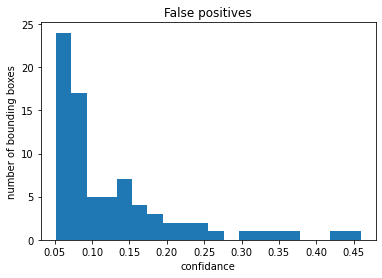

In [42]:
plt.hist(false_positives.conf, bins=20)
plt.ylabel('number of bounding boxes')
plt.xlabel('confidance')
plt.title('False positives');
plt.savefig('false_postives.png')

In [46]:
false_positives.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78 entries, 11 to 439
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   img_name  78 non-null     object 
 1   conf      78 non-null     float64
 2   true_res  78 non-null     float64
 3   is_valid  78 non-null     float64
dtypes: float64(3), object(1)
memory usage: 3.0+ KB


In [47]:
thresh = 0.3

In [50]:
false_positives[false_positives.conf > thresh].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 46 to 401
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   img_name  5 non-null      object 
 1   conf      5 non-null      float64
 2   true_res  5 non-null      float64
 3   is_valid  5 non-null      float64
dtypes: float64(3), object(1)
memory usage: 200.0+ bytes


In [51]:
false_positives_total = len(false_positives[false_positives.conf > thresh].img_name.unique())
false_positives_total

5

In [52]:
true_positives.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82 entries, 1 to 479
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   img_name  82 non-null     object 
 1   conf      82 non-null     float64
 2   true_res  82 non-null     float64
 3   is_valid  82 non-null     float64
dtypes: float64(3), object(1)
memory usage: 3.2+ KB


In [53]:
true_positives_total = len(true_positives[true_positives.conf > thresh].img_name.unique())
true_positives_total

69

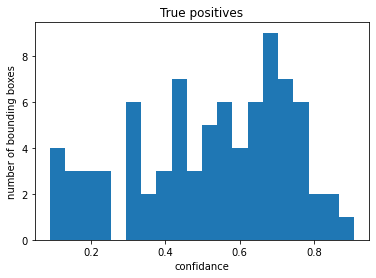

In [54]:
plt.hist(true_positives.conf, bins=20)
plt.ylabel('number of bounding boxes')
plt.xlabel('confidance')
plt.title('True positives');
plt.savefig('true_postives.png')

In [55]:
accuracy = (true_positives_total + number_bck_images - false_positives_total) / (number_bck_images+number_spag_images)
accuracy

0.8758169934640523

In [57]:
precision = true_positives_total / (true_positives_total+false_positives_total)
precision

0.9324324324324325

In [58]:
recall = true_positives_total / number_spag_images
recall

0.8313253012048193